In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from dataclasses import dataclass
import itertools
from pathlib import Path
import pickle
from typing import Optional

from jaxtyping import Float
from omegaconf import OmegaConf, DictConfig
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.encoding.ecog import ContrastiveModelSnapshot, AlignedECoGDataset, get_electrode_df, OutFile, epoch_by_state_space
from src.encoding.ecog import timit as timit_encoding
from src.utils.timit import get_word_metadata
from src.viz.epoching import plot_epoch_raster

In [57]:
sns.set_theme(style="whitegrid", context="talk", font_scale=2)

In [117]:
dataset = "timit"
rsa_analysis = "rsa_1"
study_subjects = ["EC212", "EC260"]
study_models = ["word_broad-aniso2-w2v2_8", "baseline"]
ttest_results_path = f"outputs/encoder_comparison_across_subjects/{dataset}/ttest_filtered.csv"

encoder_dirs = list(Path(f"outputs/encoders/{dataset}").glob("*/*"))
rsa_dirs = list(Path(f"outputs/rsa/{dataset}/{rsa_analysis}").glob("*/*/*"))

study_electrodes = list(itertools.chain(
    # ("EC212", 74),
    # ("EC212", 107),
    # ("EC212", 114),
    # ("EC212", 139),
    # ("EC212", 211),
    # ("EC212", 214),
    # ("EC212", 220),
    # ("EC260", 3),
    # ("EC260", 20),
    # ("EC260", 64),
    # ("EC260", 84),
    # ("EC260", 92),
    # ("EC260", 126),
    # ("EC260", 142),
    # ("EC260", 173),
    # ("EC260", 181),
    # ("EC260", 208),
    # ("EC260", 210),
    # ("EC260", 216),

    # word-dominant from timit repeats
    # [("EC212", elec) for elec in [220, 205, 107, 143, 368, 369, 123, 297, 159, 66]],
    # [("EC260", elec) for elec in [125, 166, 180, 3, 84, 173, 165]],
    [("EC212", elec) for elec in [220, 205, 107, 143]],
    [("EC260", elec) for elec in [125, 166, 165]],
))

In [5]:
encoder_dir_dict = {(p.parent.name, p.name): p for p in encoder_dirs
                    if p.name in study_subjects and p.parent.name in study_models}
rsa_dir_dict = {(p.parent.parent.name, p.parent.name, p.name): p for p in rsa_dirs
                if p.name in study_subjects and p.parent.name in study_models
                and p.parent.parent.name in study_models}

## Compute encoder improvements

In [6]:
def get_baseline_predictions(encoder_path):
    with (Path(encoder_path) / ".hydra" / "config.yaml").open() as f:
        config = OmegaConf.create(yaml.safe_load(f))
    return np.load(Path(encoder_path) / "predictions.npy")


@dataclass
class EncoderPredictions:

    config: DictConfig
    feature_spec: DictConfig
    data_spec: DictConfig

    out: OutFile
    electrode_df: pd.DataFrame

    Y: np.ndarray
    trial_onsets: np.ndarray
    predictions: np.ndarray

    @classmethod
    def from_encoder_path(cls, encoder_path):
        with (Path(encoder_path) / ".hydra" / "config.yaml").open() as f:
            config = OmegaConf.create(yaml.safe_load(f))
        feature_spec = next(iter(config.feature_sets.model_features.values()))

        data_spec = next(iter(config.data))
        out = timit_encoding.prepare_out_file(config, data_spec)

        electrode_df = get_electrode_df(config, data_spec.subject)

        X, Y, _, _, trial_onsets = timit_encoding.prepare_xy(config, data_spec)

        predictions = np.load(Path(encoder_path) / "predictions.npy")

        # Validate saved predictions with re-constructed design matrix / features
        assert predictions.shape == Y.shape

        return cls(
            config=config,
            feature_spec=feature_spec,
            data_spec=data_spec,

            out=out,
            electrode_df=electrode_df,

            Y=Y,
            trial_onsets=trial_onsets,
            predictions=predictions,
        )
    

def compute_trial_improvements(encoder_predictions: EncoderPredictions, baseline_predictions: np.ndarray):
    trial_predictions = np.split(encoder_predictions.predictions, encoder_predictions.trial_onsets[1:, 1], axis=0)
    trial_baseline_predictions = np.split(baseline_predictions, encoder_predictions.trial_onsets[1:, 1], axis=0)
    trial_Y = np.split(encoder_predictions.Y, encoder_predictions.trial_onsets[1:, 1], axis=0)
    trial_names = [encoder_predictions.out[idx]["name"] for idx in encoder_predictions.trial_onsets[:, 0]]

    # Compute R^2 within each trial and electrode
    trial_r2: Float[np.ndarray, "num_trials num_electrodes"] = np.array([r2_score(y, p, multioutput="raw_values") for y, p in zip(trial_Y, trial_predictions)])
    trial_baseline_r2 = np.array([r2_score(y, p, multioutput="raw_values") for y, p in zip(trial_Y, trial_baseline_predictions)])
    trial_r2_change = trial_r2 - trial_baseline_r2

    # Compute L2 distance by trial, electrode, time sample
    trial_l2 = [(y - p) ** 2 for y, p in zip(trial_Y, trial_predictions)]
    trial_baseline_l2 = [(y - p) ** 2 for y, p in zip(trial_Y, trial_baseline_predictions)]
    trial_l2_change = [bl - l for l, bl in zip(trial_l2, trial_baseline_l2)]

    # Pad into regular matrix
    max_len = max(len(l) for l in trial_l2)
    trial_l2_padded: Float[np.ndarray, "num_trials max_num_samples num_electrodes"] = \
        np.array([np.pad(l, ((0, max_len - len(l)), (0, 0)), mode="constant", constant_values=np.nan) for l in trial_l2])
    trial_baseline_l2_padded = np.array([np.pad(l, ((0, max_len - len(l)), (0, 0)), mode="constant", constant_values=np.nan) for l in trial_baseline_l2])
    trial_l2_change_padded = np.array([np.pad(l, ((0, max_len - len(l)), (0, 0)), mode="constant", constant_values=np.nan) for l in trial_l2_change])

    return {
        "trial_r2": trial_r2,
        "trial_baseline_r2": trial_baseline_r2,
        "trial_r2_change": trial_r2_change,

        "trial_l2": trial_l2_padded,
        "trial_baseline_l2": trial_baseline_l2_padded,
        "trial_l2_change": trial_l2_change_padded,

        "trial_names": trial_names,
    }

In [42]:
encoder_path = encoder_dir_dict["word_broad-aniso2-w2v2_8", "EC212"]
with (Path(encoder_path) / ".hydra" / "config.yaml").open() as f:
    config = OmegaConf.create(yaml.safe_load(f))
feature_spec = next(iter(config.feature_sets.model_features.values()))

data_spec = next(iter(config.data))
out = timit_encoding.prepare_out_file(config, data_spec)

electrode_df = get_electrode_df(config, data_spec.subject)

X, Y, feature_names, feature_shapes, trial_onsets = timit_encoding.prepare_xy(
    config, data_spec, center_features=False, scale_features=False)

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not match response samples (348). Trimming response
Feature samples (331) do not match response samples (333). Trimming response
Feature samples (311) do not match response samples (314). Trimming response
Feature samples (327) do not match response samples (330). Trimming response
Feature samples (247) do not match response samples (250). Trimming response
Fea

In [77]:
np.floor(X[:, -8:].min())

-2.0

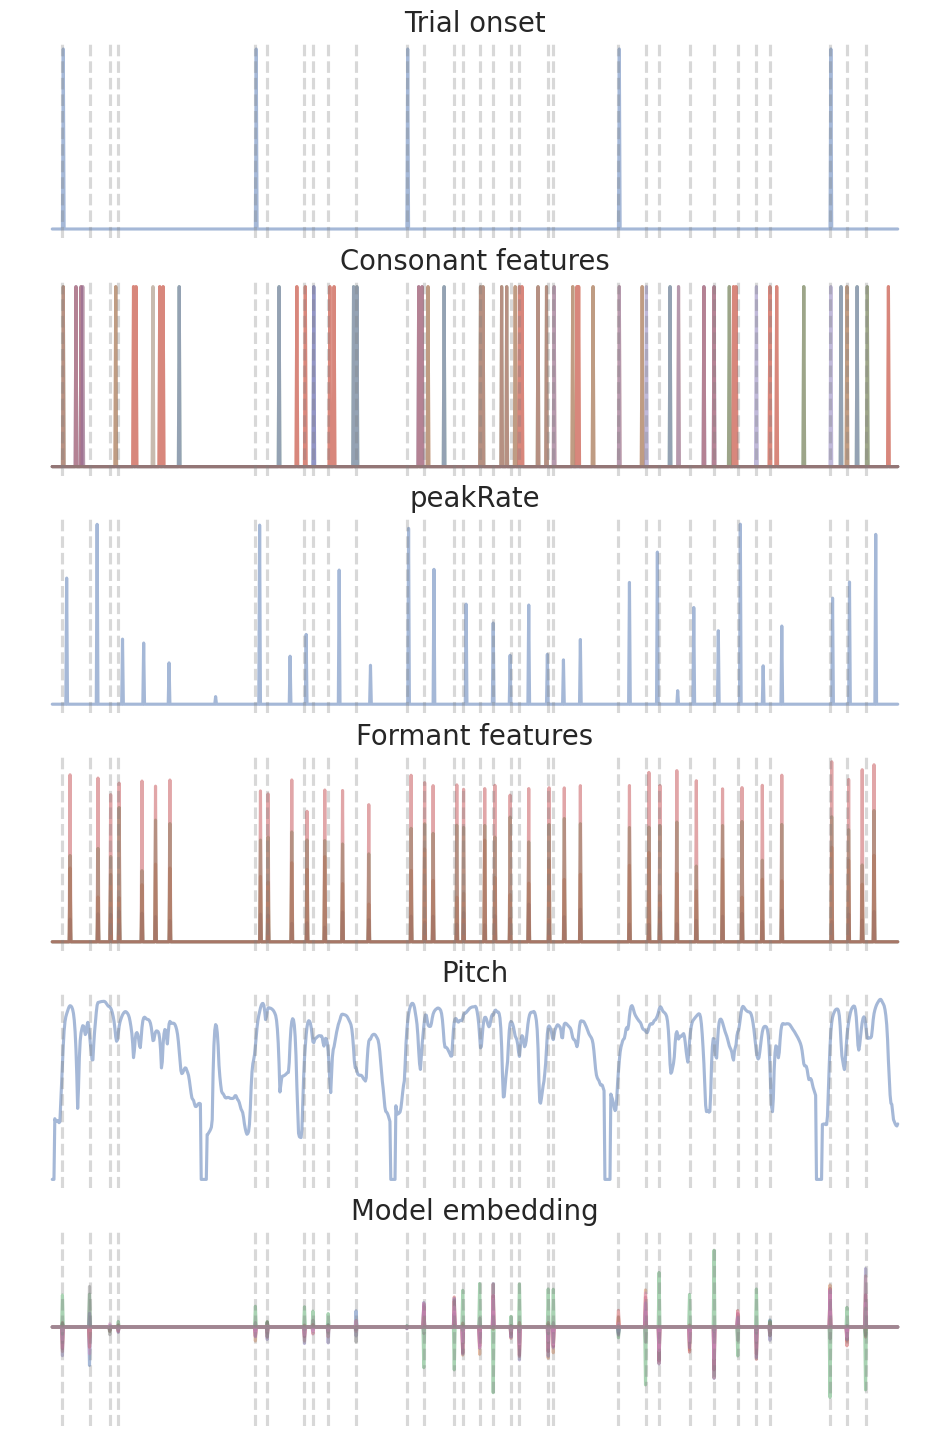

In [78]:
with sns.plotting_context("talk", font_scale=1.1):
    feature_sets = len(feature_shapes)
    feature_set_names = ["Trial onset", "Consonant features", "peakRate", "Formant features", "Pitch", "Model embedding"]
    emb_plot_ymin = np.floor(X[:, -8:]).min()
    emb_plot_ymax = np.ceil(X[:, -8:]).max()
    assert len(feature_set_names) == feature_sets
    f, axs = plt.subplots(figsize=(12, 3 * feature_sets), nrows=feature_sets)

    word_onset_samples = X[:1000, feature_names.index("model_embedding_1")].nonzero()[0]

    acc = 0
    for i, (ax, shape, name) in enumerate(zip(axs, feature_shapes, feature_set_names)):
        ax.set_title(name)
        ax.axis("off")
        if name == "Model embedding":
            ax.set_ylim((emb_plot_ymin, emb_plot_ymax))
        for j in range(shape):
            ax.plot(X[:1000, acc + j], alpha=0.5)

        # plot word onsets
        for sample in word_onset_samples:
            ax.axvline(sample, color="gray", linestyle="--", alpha=0.3)

        acc += shape

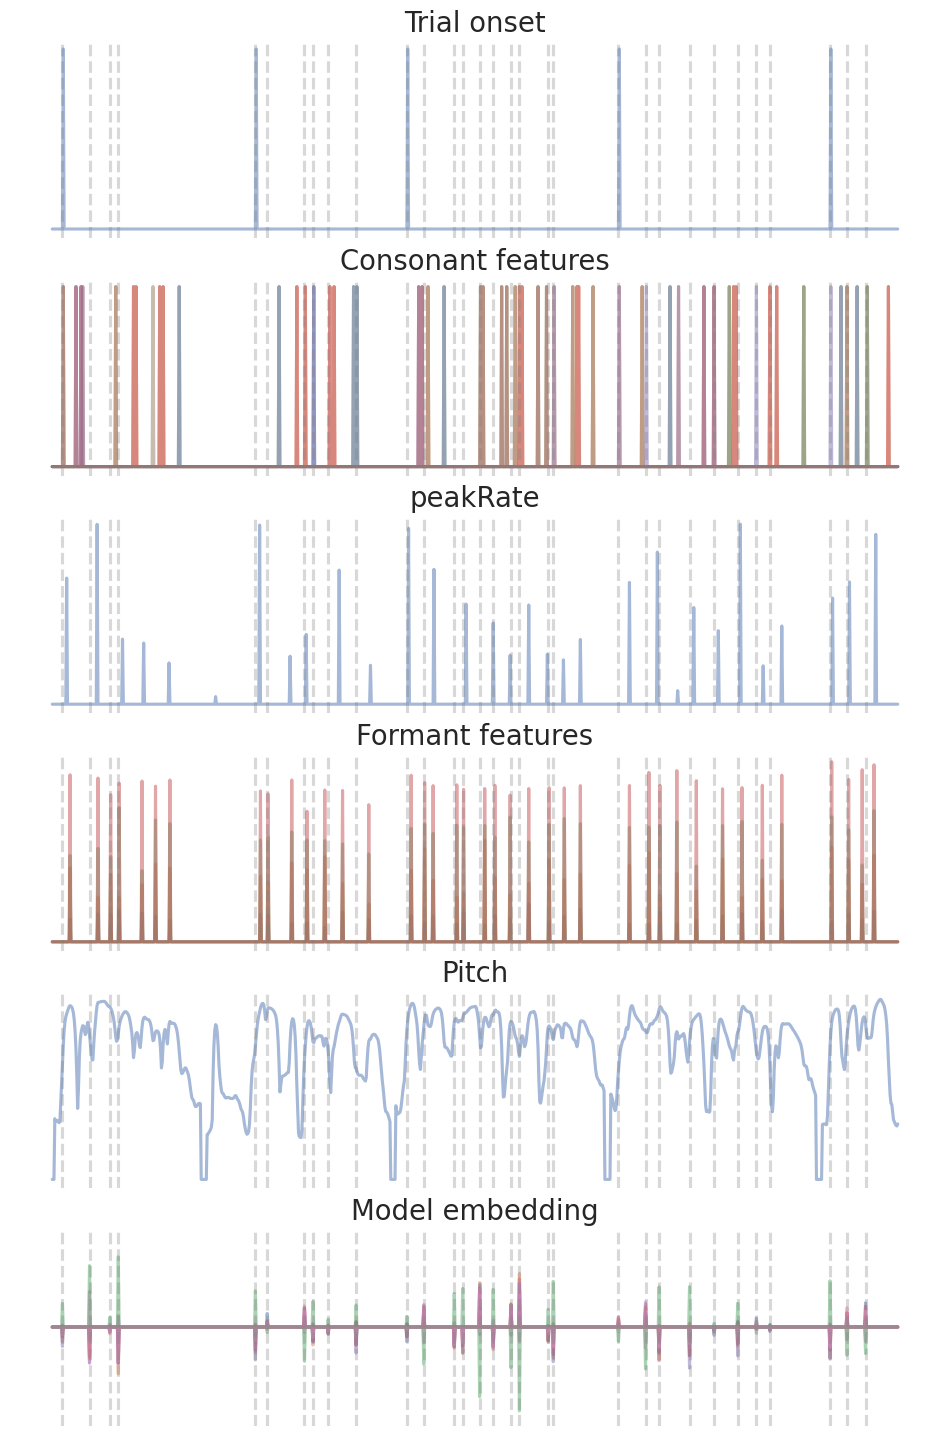

In [81]:
# Show shuffling of model embedding

X_shuffle = X.copy()
emb_nonzero = X[:, -1].nonzero()[0]
emb_nonzero_shuffle = emb_nonzero.copy()
np.random.shuffle(emb_nonzero)
X[emb_nonzero_shuffle, -8:] = X[emb_nonzero, -8:]

with sns.plotting_context("talk", font_scale=1.1):
    feature_sets = len(feature_shapes)
    feature_set_names = ["Trial onset", "Consonant features", "peakRate", "Formant features", "Pitch", "Model embedding"]
    assert len(feature_set_names) == feature_sets
    f, axs = plt.subplots(figsize=(12, 3 * feature_sets), nrows=feature_sets)

    word_onset_samples = X[:1000, feature_names.index("model_embedding_1")].nonzero()[0]

    acc = 0
    for i, (ax, shape, name) in enumerate(zip(axs, feature_shapes, feature_set_names)):
        ax.set_title(name)
        ax.axis("off")
        if name == "Model embedding":
            ax.set_ylim((emb_plot_ymin, emb_plot_ymax))
        for j in range(shape):
            ax.plot(X[:1000, acc + j], alpha=0.5)

        # plot word onsets
        for sample in word_onset_samples:
            ax.axvline(sample, color="gray", linestyle="--", alpha=0.3)

        acc += shape

In [82]:
# Compute baseline predictions first
baseline_predictions = {}
subjects = sorted(set(subject for model_embedding, subject in encoder_dir_dict.keys()))
for subject in tqdm(subjects):
    baseline_path = encoder_dir_dict["baseline", subject]
    baseline_predictions[subject] = get_baseline_predictions(baseline_path)

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
snapshots, aligned, electrode_dfs, trial_improvements = {}, {}, {}, {}
for (model_embedding, subject), encoder_dir in tqdm(list(encoder_dir_dict.items())):
    if model_embedding == "baseline":
        continue
    if subject not in baseline_predictions:
        continue

    encoder_predictions = EncoderPredictions.from_encoder_path(encoder_dir)
    electrode_dfs[subject] = encoder_predictions.electrode_df
    trial_improvements[model_embedding, subject] = compute_trial_improvements(encoder_predictions, baseline_predictions[subject])

    # construct AlignedECoGDataset
    if model_embedding not in snapshots:
        snapshot = ContrastiveModelSnapshot.from_config(encoder_predictions.config, encoder_predictions.feature_spec)
    aligned[model_embedding, subject] = AlignedECoGDataset(snapshot, encoder_predictions.out)

  0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not match response samples (348). Trimming response
Feature samples (331) do not match response samples (333). Trimming response
Feature samples (311) do not match response samples (314). Trimming response
Feature samples (327) do not match response samples (330). Trimming response
Feature samples (247) do not match response samples (250). Trimming response
Fea

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

In [84]:
trial_epochs, word_epochs, word_offset_epochs, syllable_epochs = {}, {}, {}, {}

for (model_embedding, subject), aligned_dataset in tqdm(aligned.items()):
    if subject in trial_epochs:
        continue

    subset_electrodes = [elec for subject_i, elec in study_electrodes if subject_i == subject]
    if not subset_electrodes:
        continue

    # hack together a new state space spec for sentence onset
    # nb state space bounds are inclusive, so we need to subtract 1 from the end of each bound
    trial_spec = StateSpaceAnalysisSpec(
        aligned_dataset.total_num_frames,
        ["trial"],
        [sorted([(start, end - 1) for start, end in aligned_dataset.name_to_frame_bounds.values()])],
    )
    aligned_dataset._snapshot.all_state_spaces["trial"] = trial_spec

    trial_epochs[subject] = epoch_by_state_space(
        aligned_dataset, "trial",
        epoch_window=(-0.1, 1.),
        baseline_window=(-0.1, 0.),
        pad_values=np.nan,
        subset_electrodes=subset_electrodes,
        return_df=True)
    
    word_epochs[subject] = epoch_by_state_space(
        aligned_dataset, "word",
        epoch_window=(-0.1, 0.6),
        baseline_window=None,#(-0.1, 0.),
        pad_values=np.nan,
        subset_electrodes=subset_electrodes,
        return_df=True)
    
    word_offset_epochs[subject] = epoch_by_state_space(
        aligned_dataset, "word",
        align_to="offset",
        epoch_window=(-0.2, 0.5),
        baseline_window=None,#(0., 0.1),
        pad_values=np.nan,
        subset_electrodes=subset_electrodes,
        return_df=True)
    
    # syllable_epochs[subject] = epoch_by_state_space(
    #     aligned_dataset, "syllable",
    #     epoch_window=(-0.1, 0.3),
    #     baseline_window=(-0.1, 0.),
    #     pad_values=np.nan,
    #     subset_electrodes=subset_electrodes,
    #     return_df=True)

trial_epochs = pd.concat(trial_epochs, names=["subject"]).droplevel(-1).reset_index()
word_epochs = pd.concat(word_epochs, names=["subject"]).droplevel(-1).reset_index()
word_offset_epochs = pd.concat(word_offset_epochs, names=["subject"]).droplevel(-1).reset_index()
# syllable_epochs = pd.concat(syllable_epochs, names=["subject"]).droplevel(-1).reset_index()

trial_epochs["electrode_label"] = trial_epochs.subject.str.cat(trial_epochs.electrode_idx.astype(str), sep="_")
word_epochs["electrode_label"] = word_epochs.subject.str.cat(word_epochs.electrode_idx.astype(str), sep="_")
word_offset_epochs["electrode_label"] = word_offset_epochs.subject.str.cat(word_offset_epochs.electrode_idx.astype(str), sep="_")
# syllable_epochs["electrode_label"] = syllable_epochs.subject.str.cat(syllable_epochs.electrode_idx.astype(str), sep="_")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/3052 [00:00<?, ?it/s]

  0%|          | 0/3052 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/3052 [00:00<?, ?it/s]

  0%|          | 0/3052 [00:00<?, ?it/s]

In [85]:
# Merge in word metadata
word_metadata = get_word_metadata(snapshot.all_state_spaces["word"], num_frequency_quantiles=4)
word_epochs = pd.merge(
    word_epochs, word_metadata,
    left_on=["epoch_label", "instance_idx"],
    right_on=["label", "instance_idx"],
    how="left",
    validate="many_to_one")
word_offset_epochs = pd.merge(
    word_offset_epochs, word_metadata,
    left_on=["epoch_label", "instance_idx"],
    right_on=["label", "instance_idx"],
    how="left",
    validate="many_to_one")

Missing words:  ['amorist', 'analyticity', 'autofluorescence', 'blastdown', 'boardinghouses', 'bugeyed', 'castorbeans', 'cheetal', 'conformists', 'ellipsoids', "engineers'", 'exhusband', 'fasciculations', 'frowningly', 'geocentricism', 'gyrocompass', 'hypothalamic', 'infuriation', 'keelson', 'longitudes', 'lousiness', 'madstones', "maids'", 'mealynosed', 'micrometeorite', 'micrometeorites', 'misperceives', 'morphophonemic', "motorists'", 'muddleheaded', 'mudwagon', "nan's", 'nonsystematic', "nurses'", "o'", "o'clock", 'octillion', 'overnighters', 'paramagnetic', "pilots'", 'polyesters', 'pompousness', 'radiosterilization', 'redeposition', 'regulative', 'semidrying', 'skywave', 'soysauce', 'sputniks', "students'", 'surfaceness', 'tremulously', 'unmagnified', 'uremia', "veterans'", 'warningly', 'whiplashes', 'zircons']
Word frequency quantile split:
 0.00    1.159182e+07
0.25    4.039748e+10
0.50    4.726099e+11
0.75    4.293087e+12
1.00    5.526592e+13
Name: word_frequency, dtype: float

/userdata/jgauthier/projects/ideal-word-representations/src/utils/timit.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(word_metadata.groupby("word_frequency_quantile").apply(lambda xs: xs.sample(5).index.get_level_values("label").to_list()))


In [11]:
with open("/home/jgauthier/timit_order.txt", "r") as f:
    timit_order = f.read().splitlines()
block_starts = [0, 124, 249, 375, 499]

In [12]:
trial_epochs["stimulus_idx"] = trial_epochs.name.map({name: i for i, name in enumerate(timit_order)})
trial_epochs["block_idx"] = pd.cut(trial_epochs.stimulus_idx, bins=block_starts, right=False)
assert trial_epochs.block_idx.isna().sum() == 0

In [13]:
# # compute epoch order within-electrode: loc of peak magnitude
# plot_epoch_orders = np.stack(trial_epochs.set_index("electrode_idx").loc[plot_epoch_electrodes].reset_index().set_index("epoch_time") \
#     .groupby(["electrode_idx", "epoch_idx"]).value.idxmax() \
#     .groupby("electrode_idx").apply(lambda xs: xs.droplevel(0).sort_values().index.to_numpy()) \
#     .to_numpy())

In [14]:
# from scipy.stats import spearmanr
# spearmanr(*trial_improvements["word_broad", study_subjects[0]]["trial_r2_change"][:, plot_epoch_electrodes].T)

In [15]:
# sns.lineplot(data=pd.DataFrame(trial_improvements["word_broad-aniso2-w2v2_8", "EC212"]["trial_l2_change"][:, :, 220]).reset_index().melt(id_vars="index"),
#              x="variable", y="value") 

In [16]:
# # axs = plot_epoch_raster(plot_trial_epochs[plot_trial_epochs.epoch_idx.isin(plot_epoch_orders[0, -40:-20])], encoder_predictions.electrode_df.reset_index(),
# #                         electrode_order=plot_epoch_electrodes)
# axs = plot_epoch_raster(plot_trial_epochs, encoder_predictions.electrode_df.reset_index(),
#                         electrode_order=plot_epoch_electrodes,
#                         epoch_order=plot_epoch_orders)

### Word epochs

In [102]:
plot_word_epochs = word_epochs.rename(columns={
    "epoch_time": "Epoch time (sec)",
    "value": "HGA power ($z$-score)",})

In [94]:
plot_epoch_idxs = np.array(sorted(plot_word_epochs.epoch_idx.unique()))

In [19]:
# # order by frequency
# plot_epoch_orders = plot_epoch_idxs[(plot_word_epochs.set_index("epoch_idx").word_frequency).groupby(["epoch_idx"]).mean().argsort()]

In [20]:
# order by PC
# plot_epoch_orders = plot_epoch_idxs[plot_word_epochs.groupby("epoch_idx").pca_0.mean().argsort()]

In [21]:
# # sort epochs by time of peak value
# plot_epoch_orders = np.stack(plot_word_epochs.set_index("electrode_idx").loc[plot_epoch_electrodes].reset_index().set_index("epoch_time") \
#     .groupby(["electrode_idx", "epoch_idx"]).value.idxmax() \
#     .groupby("electrode_idx").apply(lambda xs: xs.droplevel(0).sort_values().index.to_numpy()) \
#     .to_numpy())

In [22]:
# axs = plot_epoch_raster(plot_word_epochs[plot_word_epochs.electrode_idx == 211], electrode_dfs["EC212"].reset_index(),
#                         # electrode_order=plot_epoch_electrodes,
#                         epoch_order=plot_epoch_orders)

In [309]:
electrode_label_order = [f"{subject}_{elec}" for subject, elec in sorted(study_electrodes)]
relplot_kwargs = dict(
    data=plot_word_epochs,#[plot_word_epochs.electrode_label == "EC212_205"],
    x="Epoch time (sec)", y="HGA power ($z$-score)", errorbar="se",
    col="electrode_label", col_order=electrode_label_order, col_wrap=2, height=10, aspect=1.5,
    kind="line", facet_kws={"sharex": False})
def rename_titles(g):
    for ax in g.axes.flat:
        ax.set_title(ax.get_title().replace("electrode_label = ", ""))
def plot_epochs(do_ttest=[False, True], ttest_chunk_size=4, ttest_pval_threshold=1e-3,
                **kwargs):
    kwargs = {**relplot_kwargs, **kwargs}
    g = sns.relplot(**kwargs)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    rename_titles(g)

    def do_hue_ttest(rows):
        from scipy.stats import ttest_ind
        rows = rows.set_index(kwargs["hue"])
        ttest_a, ttest_b = do_ttest
        return ttest_ind(rows.loc[ttest_a, "HGA power ($z$-score)"],
                         rows.loc[ttest_b, "HGA power ($z$-score)"])

    epoch_start_time = kwargs["data"]["Epoch time (sec)"].min()
    epoch_end_time = kwargs["data"]["Epoch time (sec)"].max()
    for (row, col, hue), facet_data in g.facet_data():
        ax = g.facet_axis(row, col)
        ax.axvline(0, color="gray", linestyle="--")
        ax.axvline(0, color="gray", zorder=0)
        ax.set_xlim((epoch_start_time, epoch_end_time))
        ax.set_xticks(np.arange(-0.1, 0.61, 0.1))
        
        if do_ttest is not None:
            assert "hue" in kwargs
            chunk_grouper = facet_data.epoch_sample // ttest_chunk_size
            ttest_input = facet_data.dropna().groupby(["epoch_idx", kwargs["hue"], chunk_grouper], observed=True) \
                [kwargs["y"]].mean().reset_index()
            ttest_results = ttest_input.groupby(ttest_input.epoch_sample) \
                .apply(do_hue_ttest)
            if len(ttest_results) > 0:
                for chunk, (t, p) in ttest_results.items():
                    if p < ttest_pval_threshold:
                        # draw thin rectangle at top of axis
                        from matplotlib.patches import Rectangle
                        import matplotlib.transforms as trans
                        transform = trans.blended_transform_factory(ax.transData, ax.transAxes)

                        chunk_onset = chunk * ttest_chunk_size / 100 + epoch_start_time
                        chunk_width = ttest_chunk_size / 100
                        ax.add_patch(Rectangle((chunk_onset, 0.925), chunk_width, 0.05,
                                               color="gray", alpha=0.2, transform=transform))
                        
    return g

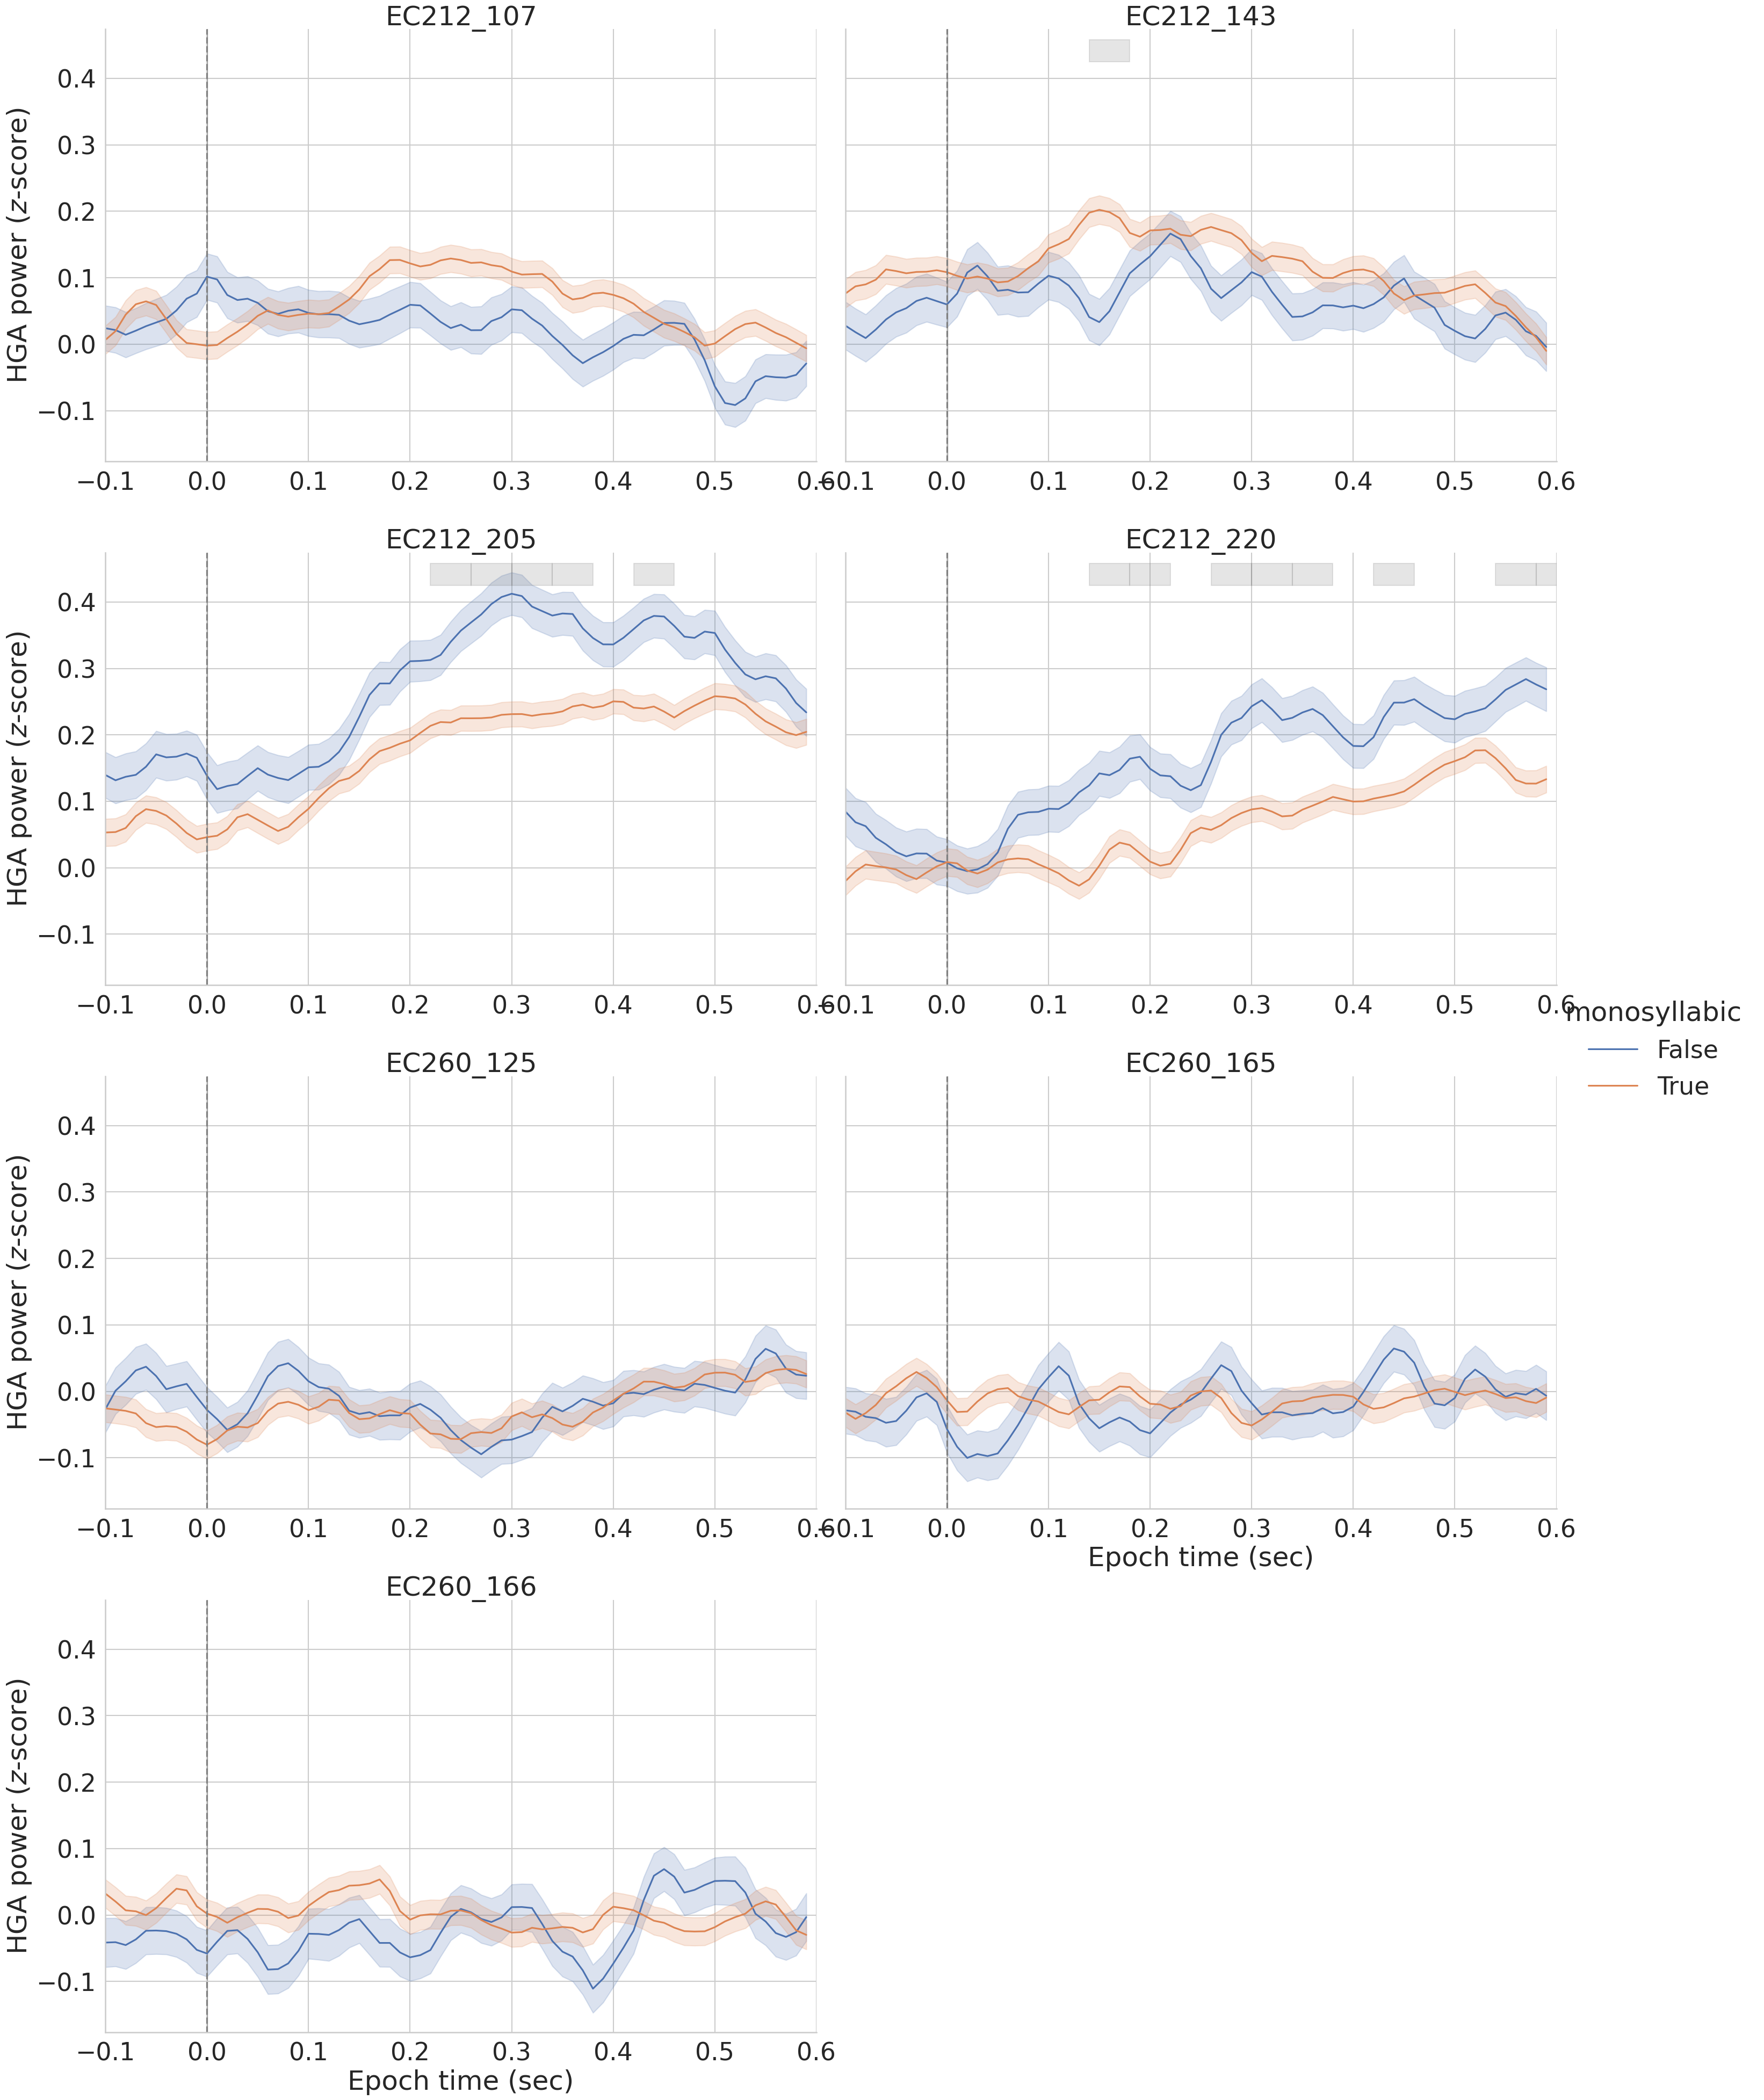

In [281]:
plot_epochs(hue="monosyllabic")

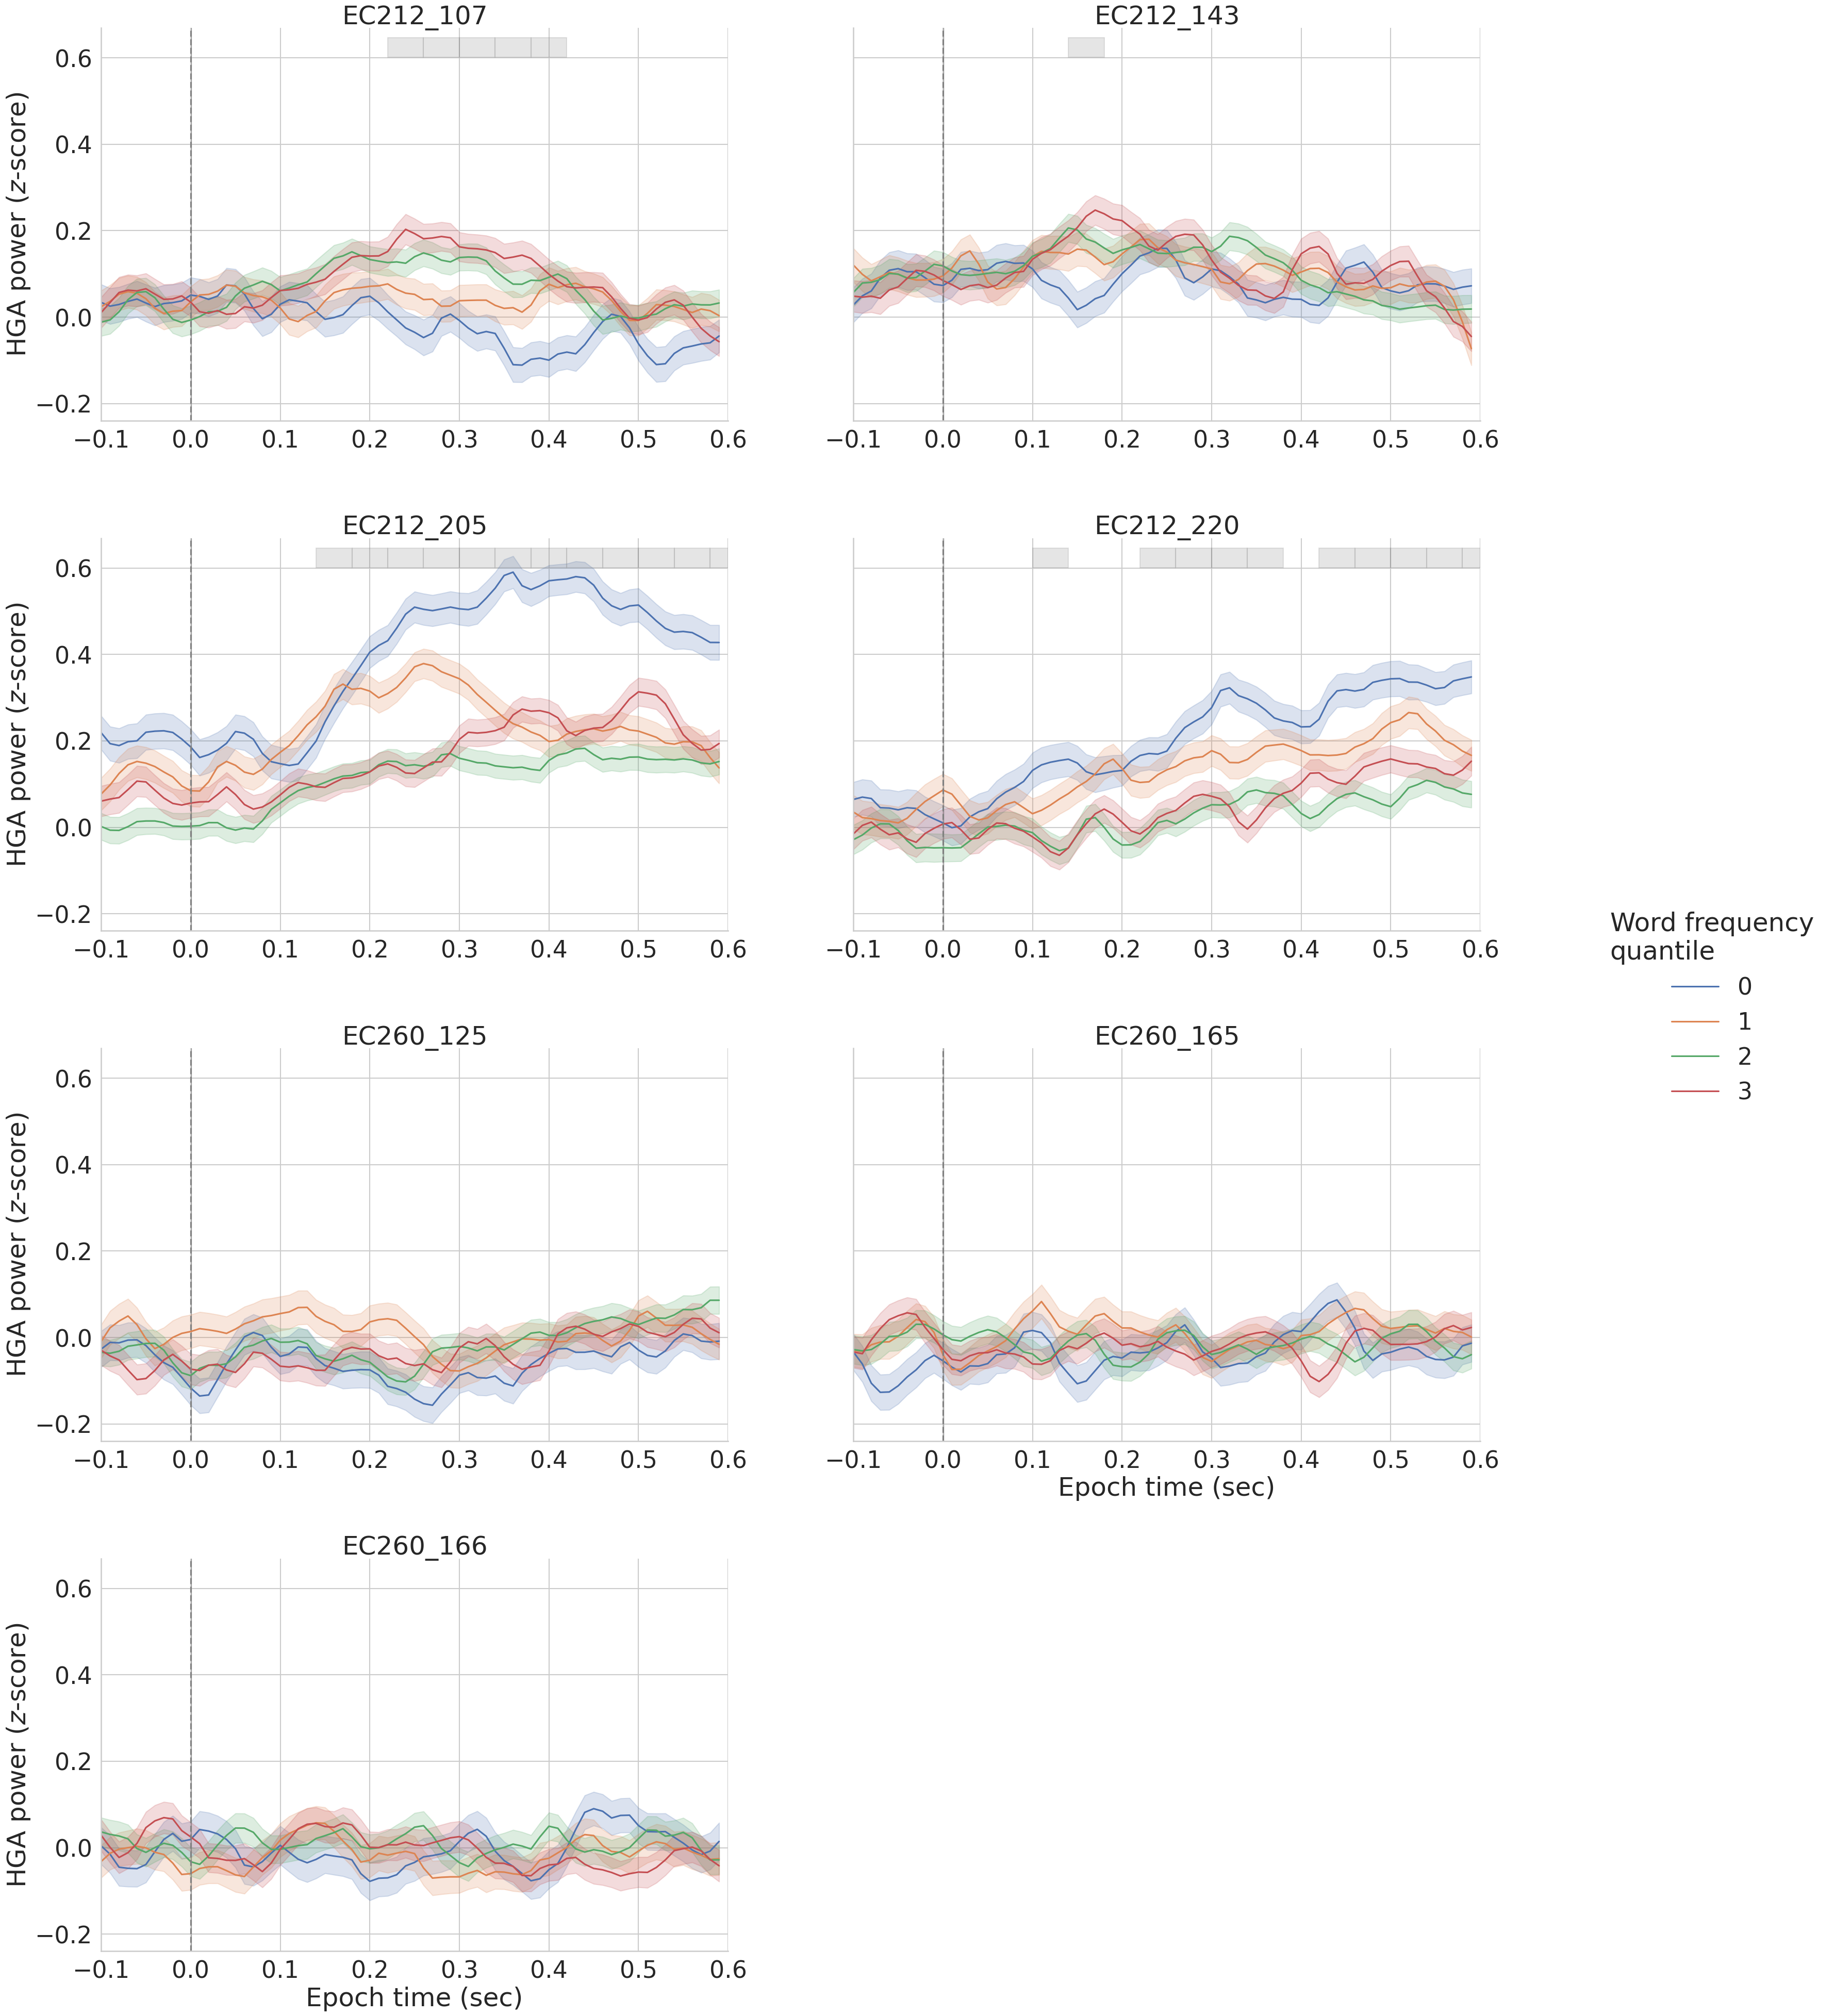

In [311]:
g = plot_epochs(do_ttest=["0", "3"], hue="word_frequency_quantile")
g.legend.set_title("Word frequency\nquantile")

In [287]:
# plot_word_epochs["pca0_onset"] = plot_word_epochs.onset_phoneme.isin(['AH', 'IH', 'EY', 'ER', 'EH', 'HH', 'UH', 'IY', 'W', 
#        'AE', 'Y', 'AO', 'AA', 'OW', 'L', 'OY', "NG", "M", "N",
#        'AW', 'AY', 'UW'])
plot_word_epochs["Sonorant onset"] = plot_word_epochs.onset_phoneme.isin(['AH', 'IH', 'EY', 'ER', 'EH', 'HH', 'UH', 'IY', 'W', 
       'AE', 'Y', 'AO', 'AA', 'OW', 'L', 'OY',
       'AW', 'AY', 'UW', 'R',
       "M", "N", "B", "V", "DH", "G",])

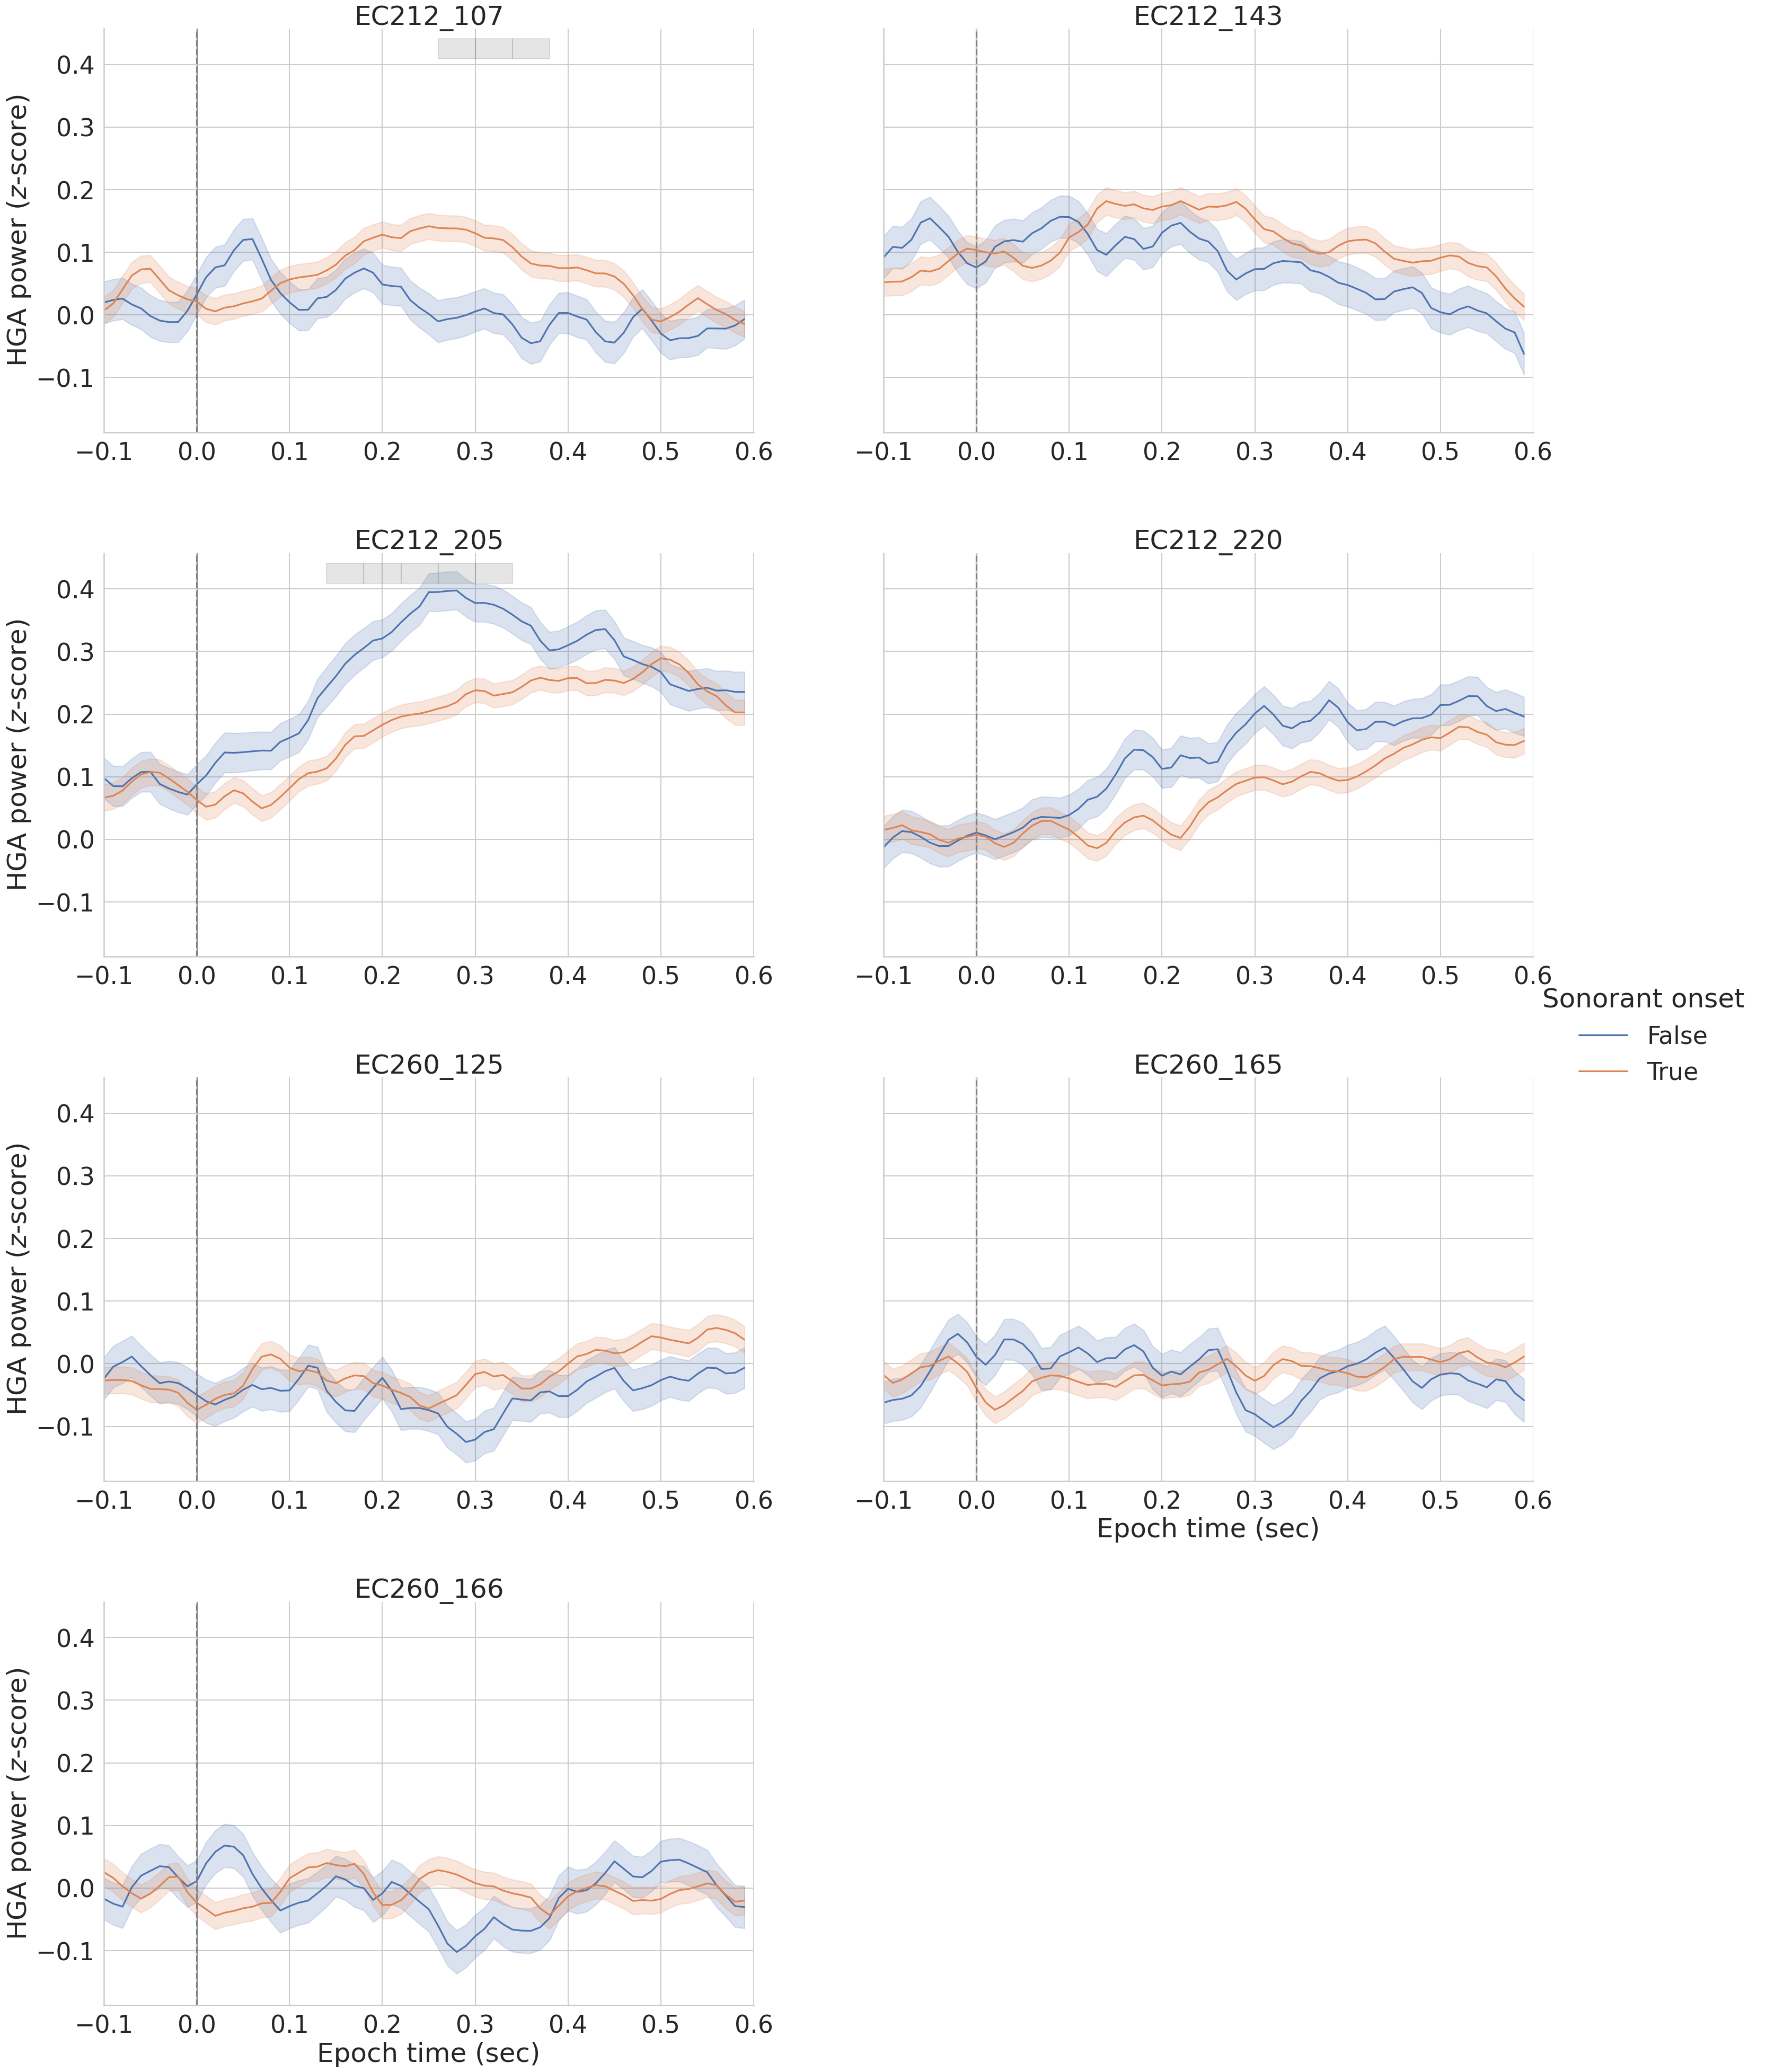

In [288]:
plot_epochs(hue="Sonorant onset")

In [315]:
reg_study = plot_word_epochs[(plot_word_epochs.electrode_label == "EC212_205") & plot_word_epochs["Epoch time (sec)"].between(0.4, 0.5)] \
    .groupby(["epoch_idx", "word_frequency", "num_syllables"])["HGA power ($z$-score)"].mean().reset_index()
# reg_study = plot_word_epochs[(plot_word_epochs.electrode_label == "EC260_165") & plot_word_epochs["Epoch time (sec)"].between(0.35, 0.45)] \
#     .groupby(["epoch_idx", "word_frequency", "num_syllables"])["HGA power ($z$-score)"].mean().reset_index()
# reg_study = plot_word_epochs[(plot_word_epochs.electrode_label == "EC212_143") & plot_word_epochs["Epoch time (sec)"].between(0.125, 0.175)] \
#     .groupby(["epoch_idx", "word_frequency", "num_syllables"])["HGA power ($z$-score)"].mean().reset_index()
# reg_study = plot_word_epochs[(plot_word_epochs.electrode_label == "EC212_220") & plot_word_epochs["Epoch time (sec)"].between(0.45, 0.55)] \
#     .groupby(["epoch_idx", "word_frequency", "num_syllables"])["HGA power ($z$-score)"].mean().reset_index()

In [316]:
reg_study.to_csv("reg_study-EC212_205.csv")
# reg_study.to_csv("reg_study-EC260_165.csv")
# reg_study.to_csv("reg_study-EC212_143.csv")
# reg_study.to_csv("reg_study-EC212_220.csv")

### Word offset epochs

In [253]:
word_offset_epochs = word_offset_epochs.rename(columns={
    "epoch_time": "Epoch time (sec)",
    "value": "HGA power ($z$-score)",})

In [312]:
def plot_offset_epochs(do_ttest=[False, True], ttest_chunk_size=4, ttest_pval_threshold=1e-3, **kwargs):
    kwargs = {**relplot_kwargs, **kwargs}
    kwargs["data"] = word_offset_epochs
    g = sns.relplot(**kwargs)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    rename_titles(g)
    for ax in g.axes.flat:
        ax.axvline(0, color="gray", linestyle="--")
        ax.set_xlabel("Time from word offset (sec)")

    def do_hue_ttest(rows):
        from scipy.stats import ttest_ind
        rows = rows.set_index(kwargs["hue"])
        ttest_a, ttest_b = do_ttest
        return ttest_ind(rows.loc[ttest_a, "HGA power ($z$-score)"],
                         rows.loc[ttest_b, "HGA power ($z$-score)"])

    epoch_start_time = kwargs["data"]["Epoch time (sec)"].min()
    epoch_end_time = kwargs["data"]["Epoch time (sec)"].max()
    for (row, col, hue), facet_data in g.facet_data():
        ax = g.facet_axis(row, col)
        ax.axvline(0, color="gray", linestyle="--")
        ax.axvline(0, color="gray", zorder=0)
        ax.set_xlim((epoch_start_time, epoch_end_time))
        ax.set_xticks(np.arange(epoch_start_time, epoch_end_time + 0.01, 0.1))
        
        if do_ttest is not None:
            assert "hue" in kwargs
            chunk_grouper = facet_data.epoch_sample // ttest_chunk_size
            ttest_input = facet_data.dropna().groupby(["epoch_idx", kwargs["hue"], chunk_grouper], observed=True) \
                [kwargs["y"]].mean().reset_index()
            ttest_results = ttest_input.groupby(ttest_input.epoch_sample) \
                .apply(do_hue_ttest)
            if len(ttest_results) > 0:
                for chunk, (t, p) in ttest_results.items():
                    if p < ttest_pval_threshold:
                        # draw thin rectangle at top of axis
                        from matplotlib.patches import Rectangle
                        import matplotlib.transforms as trans
                        transform = trans.blended_transform_factory(ax.transData, ax.transAxes)

                        chunk_onset = chunk * ttest_chunk_size / 100 + epoch_start_time
                        chunk_width = ttest_chunk_size / 100
                        ax.add_patch(Rectangle((chunk_onset, 0.925), chunk_width, 0.05,
                                               color="gray", alpha=0.2, transform=transform))
                        
    return g

In [305]:
# plot_offset_epochs(hue="monosyllabic")

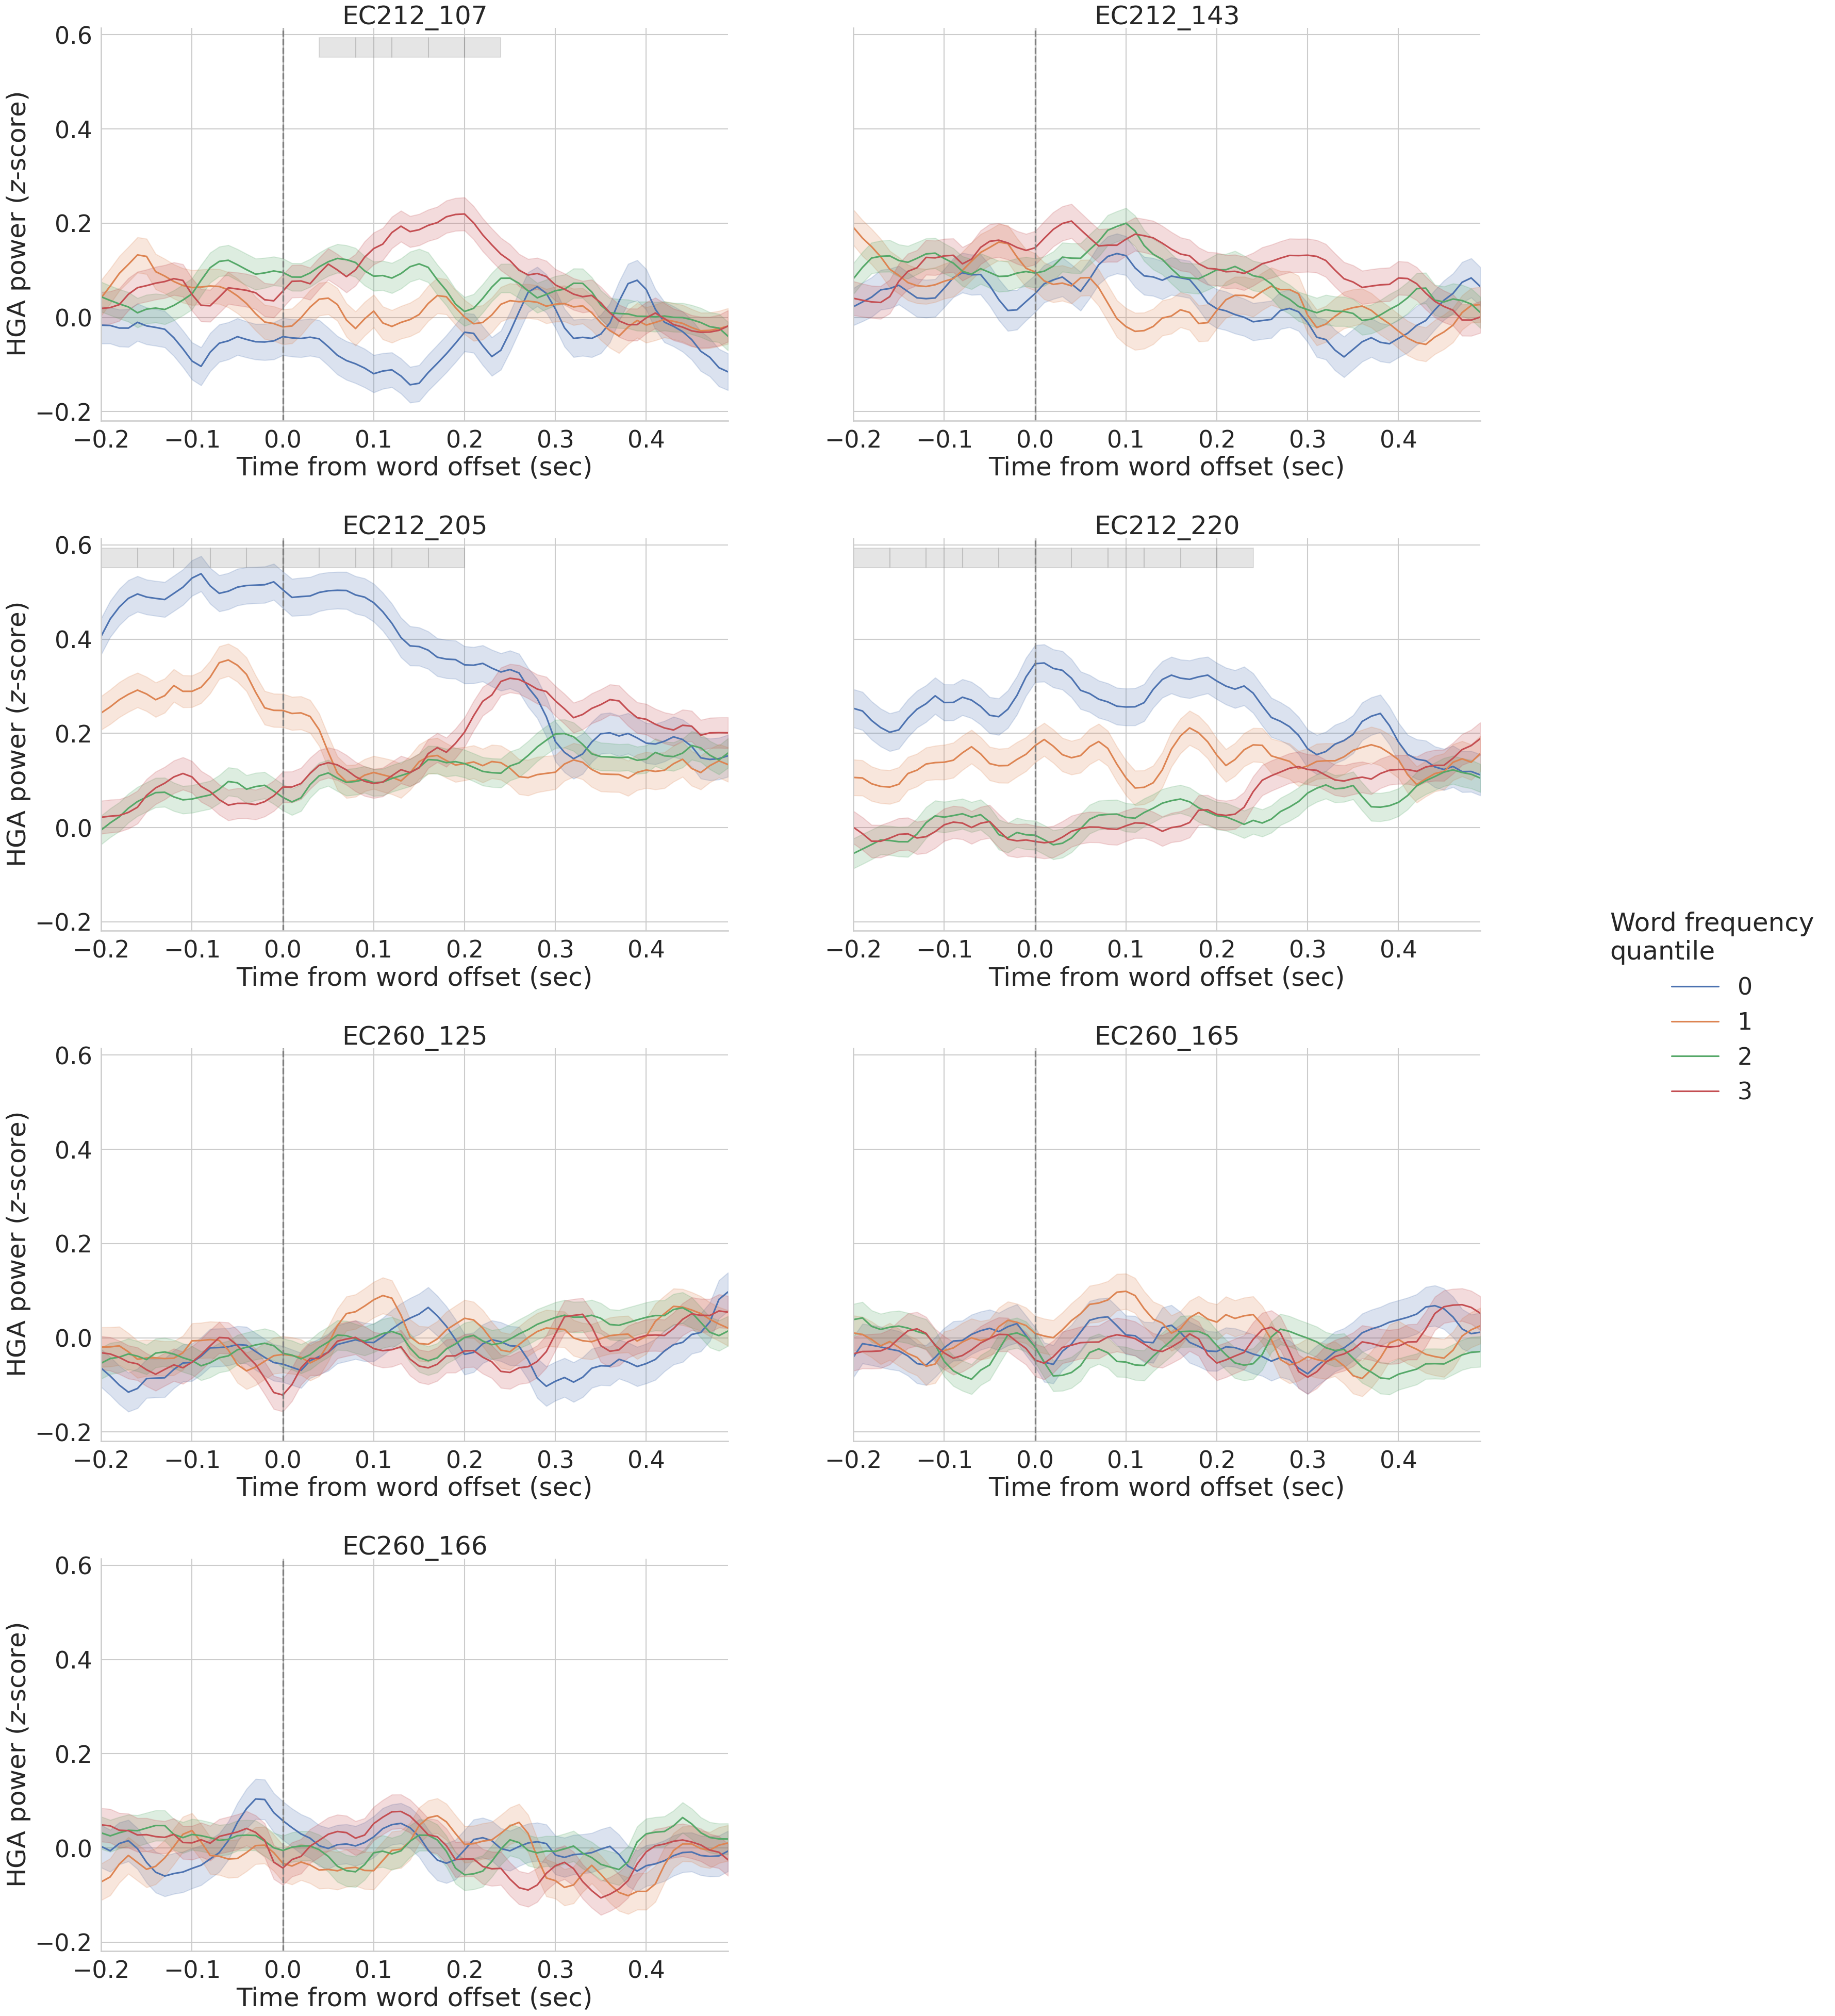

In [313]:
g = plot_offset_epochs(do_ttest=["0", "3"], hue="word_frequency_quantile")
g.legend.set_title("Word frequency\nquantile")

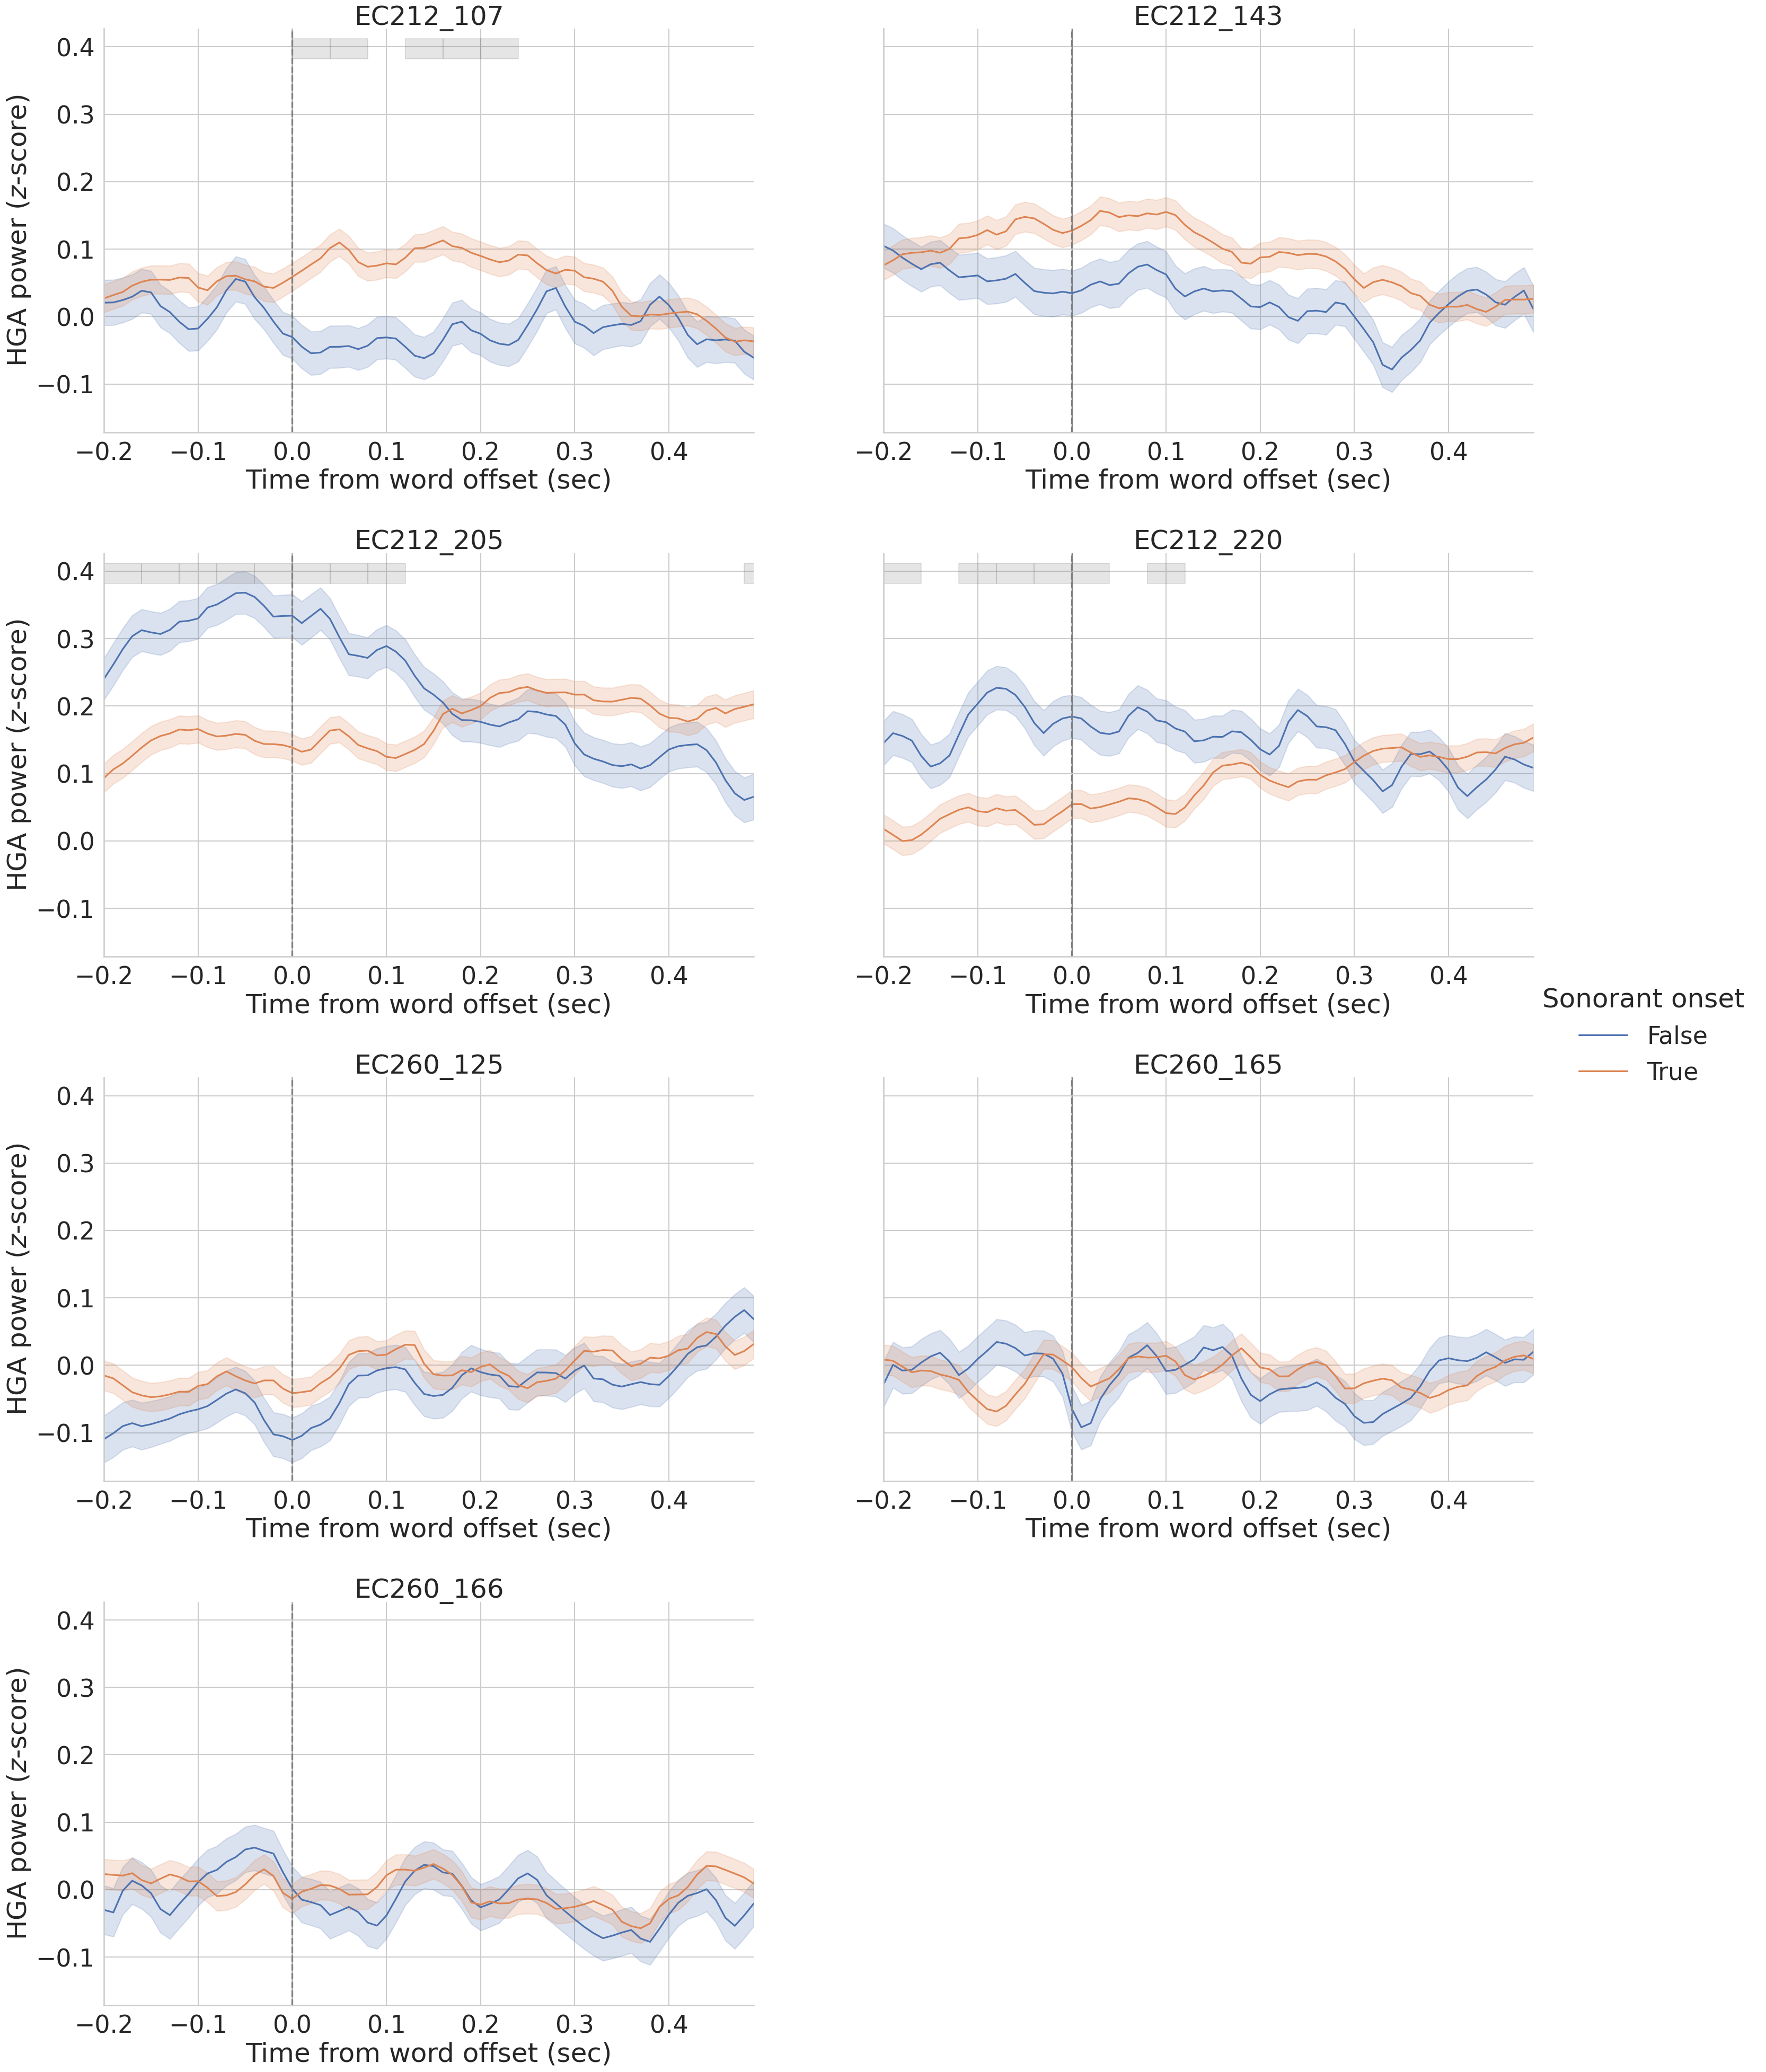

In [307]:
word_offset_epochs["Sonorant onset"] = word_offset_epochs.onset_phoneme.isin(['AH', 'IH', 'EY', 'ER', 'EH', 'HH', 'UH', 'IY', 'W', 
       'AE', 'Y', 'AO', 'AA', 'OW', 'L', 'OY',
       'AW', 'AY', 'UW', 'R',
       "M", "N", "B", "V", "DH", "G",])
plot_offset_epochs(hue="Sonorant onset")

### Syllable rasters

  0%|          | 0/2 [00:00<?, ?it/s]

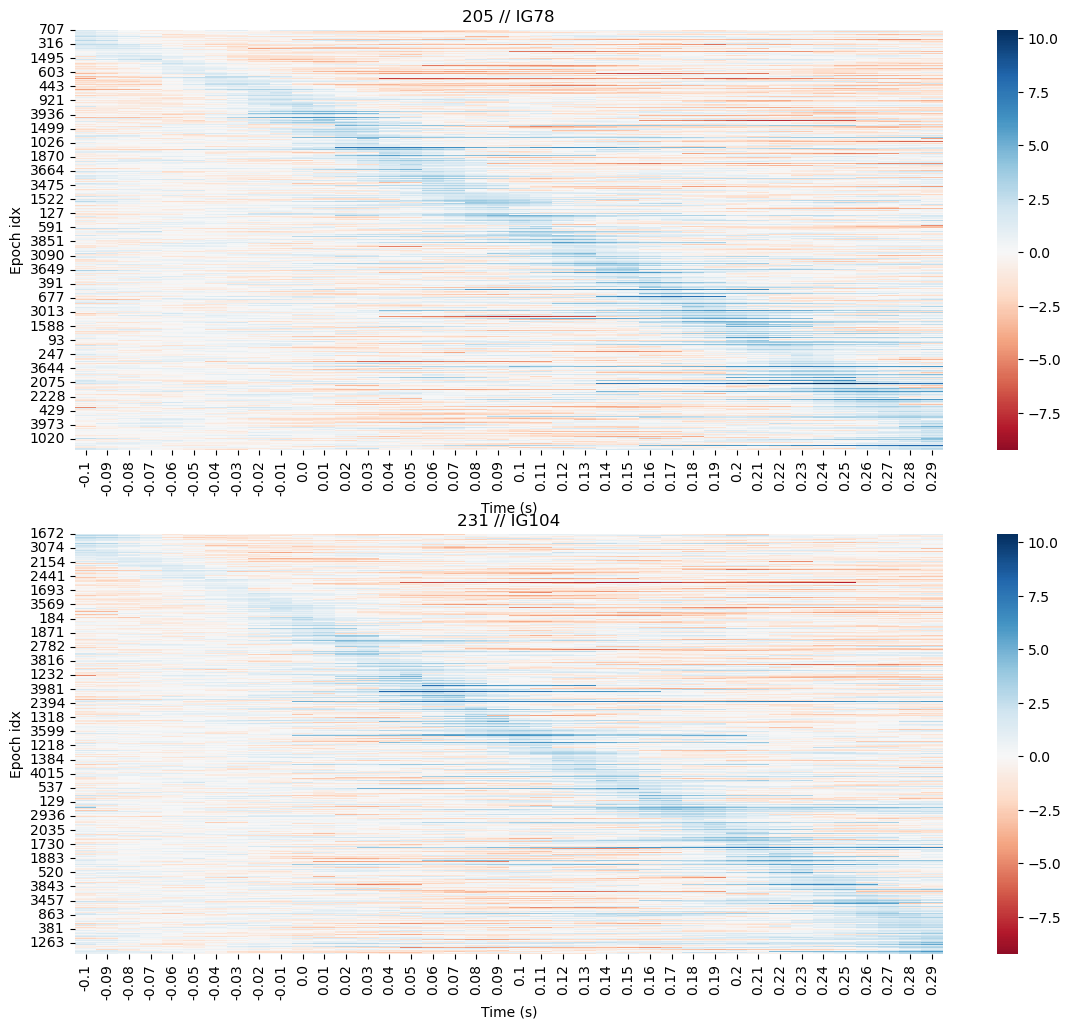

In [144]:
plot_epoch_electrodes = [205, 231]
plot_syllable_epochs = syllable_epochs[syllable_epochs.electrode_idx.isin(plot_epoch_electrodes)]
# sort epochs by time of peak value
plot_epoch_orders = np.stack(plot_syllable_epochs.set_index("epoch_time") \
    .groupby(["electrode_idx", "epoch_idx"]).value.idxmax() \
    .groupby("electrode_idx").apply(lambda xs: xs.droplevel(0).sort_values().index.to_numpy()) \
    .to_numpy())
axs = plot_epoch_raster(plot_syllable_epochs, encoder_predictions.electrode_df.reset_index(),
                        electrode_order=plot_epoch_electrodes,
                        epoch_order=plot_epoch_orders)